In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from rich import print
import numpy as np
import json
from langdetect import detect, LangDetectException, DetectorFactory
from typing import List
from arabert.preprocess import ArabertPreprocessor
import re
DetectorFactory.seed = 0
from pyarabic.araby import strip_diacritics, normalize_hamza
import matplotlib.pyplot as plt 

In [2]:
data_path = '../../data/raw/Full FCIT data no names.xlsx'

df = pd.read_excel(data_path)

df.head(10)

,1-(مخطط المقرر واضح بالنسبة لي بما في ذلك المعلومات والمهارات التي صمم المقرر لتطويرها)- (The course outline (including the knowledge and skills the course was designed to develop) was made clear to me),"2-متطلبات اجتياز المقرر واضحة بالنسبة لي (بما في ذلك الواجبات التي يتم التقييم بناء عليها، وطرق التقييم))- (The things I had to do to succeed in the course, including assessment tasks and criteria for assessment, were made clear to me)","3-مصادر المساعدة في المقرر واضحة بالنسبة لي (بما في ذلك الساعات المكتبية لعضو هيئة التدريس، المراجع))- (Sources of help for me during the course including faculty office hours and reference material, were made clear to me)",4-(تنفيذ المقرر والتكاليف التي طُلبت مني متماشية مع مخطط المقرر)- (The conduct of the course and assignments I was asked to do were consistent with the course outline),"5-(كل ما يقدم في المقرر حديث ومفيد، (المراجع، الملخصات، وما شابهها))- (Course materials were of up to date and useful. (Texts, handouts, references etc.))","6-(المصادر التي احتجتها في هذا المقرر متوافرة)- (The resources I needed in this course (textbooks, library, computers etc.) were available when I needed them.)","7-(تم استخدام التقنية بشكل فعال)- (In this course, effective use was made of technology to support my learning)",8-(في هذا المقرر وجدت تشجيعاً لإلقاء الأسئلة وتطوير أفكاري)- (In this course I was encouraged to ask questions and develop my own ideas),"9-(في هذا المقرر شُجعت على تقديم أفضل ما عندي)- (In this course, I was inspired to do my best work)","10-(في هذا المقرر ساعدت الأشياء التي طُلبت مني (الأنشطة الصفية، المعامل، وغيرها) في تطوير معرفتي ومهاراتي التي يهدف المقرر لتعليمها)- (The things I had to do in this course (class activities, assignments, laboratories etc.) were helpful for developing the knowledge and skills the course was intended to teach)",...,28-(تتناسب طرق التدريس مع بيئة الفصول الافتراضية)- (Teaching methods adapted are appropriate for the virtual classroom environment),29-(أجد أن بيئة الفصول الافتراضية محفزة للتعلم)- (I find that the virtual classroom is a motivating environment for learning),30-(توفر أدلة للتدريب والمساعدة على استخدام التقنيات في الفصول الافتراضية)- (training and assistance guides and manuals on how .to use the tools are available in the virtual classroom),31-(تتوفر المحاضرات مسجلة بشكل واضح)- (Recordings of the Lectures are available on the platform),32-(تتناسب طرق التقييم مع بيئة الفصول الافتراضية)- (Assessment methods adapted are appropriate for the virtual classroom environment),"33-(بشكل عام أنا راض عن خدمات التعلم الإلكتروني والتعليم عن بعد)- (In general, I am satisfied with e-learning and distance education services)",34-(اقتراحات تود إضافتها)-(Suggestions to add),35-(أكثر ما أعجبك في هذا المقرر)-What did you like most about this course,36-(أكثر ما لم يعجبك في هذا المقرر)-What did you dislike most about this course,37-(هل لديك اقتراحات لتحسين المقرر)-What suggestion(s) do you have to improve this course
0,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,...,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,لايوجد,المقرر بشكل عام,لايوجد,لايوجد
1,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,...,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,لايوجد,المقرر بشكل عام,لايوجد,لايوجد
2,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أوافق بشدة,Strongly Agree-أ

In [3]:
# select the last 4 columns
raw = df.iloc[:, -4:]
raw.tail()

,34-(اقتراحات تود إضافتها)-(Suggestions to add),35-(أكثر ما أعجبك في هذا المقرر)-What did you like most about this course,36-(أكثر ما لم يعجبك في هذا المقرر)-What did you dislike most about this course,37-(هل لديك اقتراحات لتحسين المقرر)-What suggestion(s) do you have to improve this course
3074,لايوجد,لايوجد,لايوجد,اضافة بعض الجزء العملي من المقرر
3075,Excellent,All,Nothing,No
3076,Its very nice and important course👍🏻,Every thing,Nothing,No
3077,لايوجد,المحتوى,بايوجد,لا
3078,Practical session,The values,Nothing,No


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3079 entries, 0 to 3078
Data columns (total 4 columns):
 #   Column                                                                                     Non-Null Count  Dtype 
---  ------                                                                                     --------------  ----- 
 0   34-(اقتراحات تود إضافتها)-(Suggestions to add)                                             3040 non-null   object
 1   35-(أكثر ما أعجبك في هذا المقرر)-What did you like most about this course                  3052 non-null   object
 2   36-(أكثر ما لم يعجبك في هذا المقرر)-What did you dislike most about this course            3044 non-null   object
 3   37-(هل لديك اقتراحات لتحسين المقرر)-What suggestion(s) do you have to improve this course  3044 non-null   object
dtypes: object(4)
memory usage: 96.3+ KB


In [5]:
data = raw.copy()

new_col_names = {
    # 34-(اقتراحات تود إضافتها)-(Suggestions to add)
    data.columns[0]: 'add_suggestions',
    # 35-(أكثر ما أعجبك في هذا المقرر)-What did you like most about this course
    data.columns[1]: 'like',
    # 36-(أكثر ما لم يعجبك في هذا المقرر)-What did you dislike most about this course
    data.columns[2]: 'dislike',
    # 37-(هل لديك اقتراحات لتحسين المقرر)-What suggestion(s) do you have to improve this course
    data.columns[3]: 'improve_course'
}

data = data.rename(columns=new_col_names)
data.head()

,add_suggestions,like,dislike,improve_course
0,لايوجد,المقرر بشكل عام,لايوجد,لايوجد
1,لايوجد,المقرر بشكل عام,لايوجد,لايوجد
2,لايوجد,طريقة الشرح,لايوجد,لايوجد
3,-,-,-,-
4,-,-,-,-


add_suggestions    39
like               27
dislike            35
improve_course     35
dtype: int64

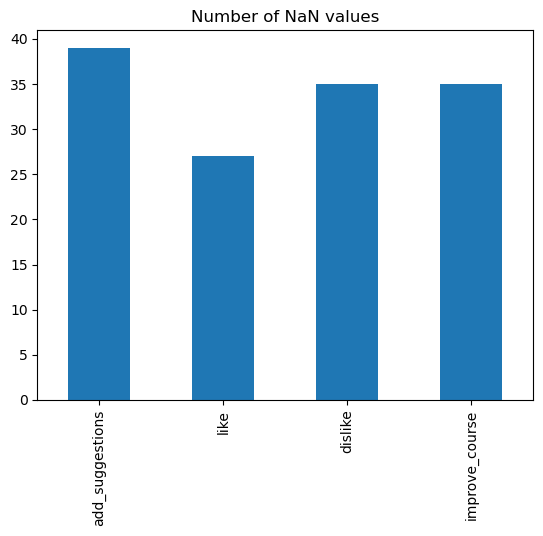

In [6]:
def plot_nan_values(data, title=None):
    print(data.isna().sum())
    data.isna().sum().plot(kind='bar')
    
    if title:
        plt.title(title)
    else:
        plt.title('Number of NaN values')
    plt.show()

plot_nan_values(data)

# Process text

In [7]:
def apply_fn(data, fn, columns, **kwargs):
    """Apply a function to multiple columns.

    Args:
        data (pd.DataFrame): pandas dataframe
        fn (function): python function
        columns (list): list of column names

    Returns:
        pd.DataFrame: pandas data frame after applying the function.
    """
    data_c = data.copy()
    for col in columns:
        data_c[col] = data_c[col].apply(fn, **kwargs)
    return data_c

In [8]:
arabert_prep = ArabertPreprocessor(model_name="aubmindlab/bert-base-arabertv2")

[2024-06-03 01:26:48,437 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [9]:
def process_text(text):
    if text is not np.nan:
        text = str(text)
        text = text.lower()
        clean_text = text.replace("لايوجد", "لا يوجد")

        # do some general preprocessing using arabert
        clean_text = arabert_prep.preprocess(clean_text)
        clean_text = arabert_prep.unpreprocess(clean_text)

        # replace line breakers with space
        clean_text = clean_text.replace("\n", " ")
        # حذف الزخرفات المختلفة
        clean_text = strip_diacritics(clean_text)
        # توحيد الهمزة
        # clean_text = normalize_hamza(clean_text, method="tasheel")
        # remove extra inner spaces
        clean_text = re.sub(r"\s+", " ", clean_text)
        # remove trailing white spaces
        clean_text = clean_text.strip()

        return clean_text
    
    else: 
        return np.nan

In [10]:
data = apply_fn(data, process_text, data.columns)

In [11]:
data.head()

,add_suggestions,like,dislike,improve_course
0,لا يوجد,المقرر بشكل عام,لا يوجد,لا يوجد
1,لا يوجد,المقرر بشكل عام,لا يوجد,لا يوجد
2,لا يوجد,طريقة الشرح,لا يوجد,لا يوجد
3,-,-,-,-
4,-,-,-,-


# Find most frequent values

In [12]:
data['add_suggestions'].value_counts().nlargest(5)

لا يوجد    1345
.           821
-            97
nothing      91
no           63
Name: add_suggestions, dtype: int64

In [13]:
# calculate most frequent values in each column
topk = 15

most_frequent_values = {
    col_name: data[col_name].value_counts().nlargest(topk) for col_name in data.columns
}

In [14]:
for k, v in most_frequent_values.items():
    print('=='*20)
    print(f'Most frequent values in ({k})')
    print('=='*20)
    print(v)

========================================

Most frequent values in (add_suggestions)

========================================

لا يوجد         1345
.                821
-                 97
nothing           91
no                63
لا                49
..                36
none              34
لا شيء            24
non               17
المادة رائعة      13
لاشيء             12
لاتوجد            11
شكرا              11
لاشي              11
Name: add_suggestions, dtype: int64

========================================

Most frequent values in (like)

========================================

لا يوجد         922
.               832
-                81
everything       51
..               39
لا               25
no               23
none             22
all              17
كل شيء           17
كل شي            14
nothing          14
لا شيء           13
المادة رائعة     13
كل شئ            11
Name: like, dtype: int64

========================================

Most frequent values in (dislike)

========================================

لا يوجد          1383
.                 829
nothing           120
-                  97
..                 39
لا                 36
no                 32
none               29
لا شيء             27
لاشيء              20
لا شي              18
non                14
لاشي               13
- -                 9
المدة الزمنية       9
Name: dislike, dtype: int64

========================================

Most frequent values in (improve_course)

========================================

لا يوجد    1313
.           822
لا          130
no          130
-            98
..           42
nothing      38
none         22
non          17
لا شي        13
شكرا         11
- -          11
لاشيء         8
0             7
لاشي          7
Name: improve_course, dtype: int64

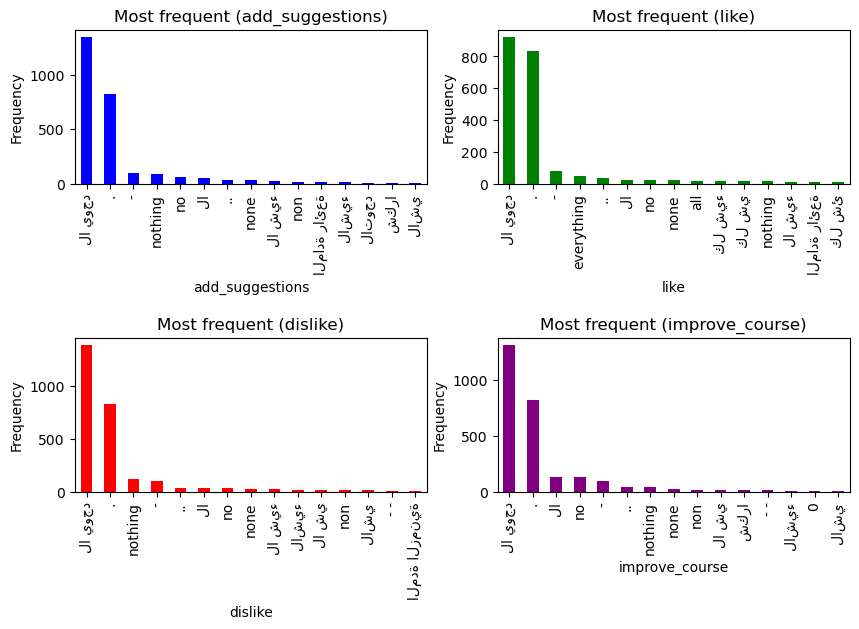

In [15]:
# plot most frequent values
plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=1)
color_list = ['blue', 'green', 'red', 'purple']

for i, (col_name, freq_values) in enumerate(most_frequent_values.items()):
    plt.subplot(2, 2, i+1)
    freq_values.plot(kind='bar', color=color_list[i])
    plt.title(f'Most frequent ({col_name})')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    # plt.xticks(rotation=45)


# Remove the most frequent values

In [16]:
for col_name, freq_values in most_frequent_values.items():
    data[col_name] = data[col_name].replace(freq_values.index.to_list(), np.nan)

In [17]:
data.sample(10)

,add_suggestions,like,dislike,improve_course
2705,NaN,NaN,NaN,NaN
2635,NaN,NaN,NaN,NaN
1577,NaN,NaN,NaN,NaN
2376,NaN,NaN,لا شئ,زيادة الجانب العملي
2368,لا يوحد,التقنية المستخدمة,NaN,NaN
893,NaN,NaN,NaN,NaN
490,NaN,NaN,NaN,NaN
1040,NaN,NaN,NaN,NaN
1775,NaN,NaN,NaN,NaN
118,NaN,NaN,NaN,NaN


add_suggestions    2674
like               2121
dislike            2710
improve_course     2704
dtype: int64

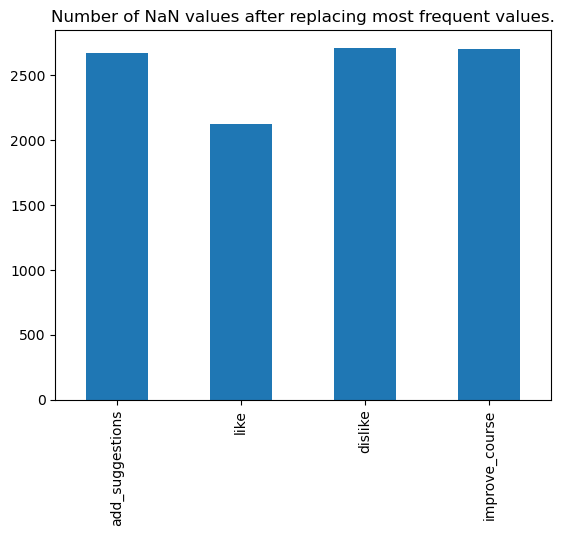

In [18]:
plot_nan_values(data, title='Number of NaN values after replacing most frequent values.')

# Remove short strings

In [19]:
short_words = []

In [20]:
def remove_short_str(row, n_chars=5):
    if len(str(row)) >= n_chars and row is not np.nan:
        return row
    
    short_words.append(row)
    return np.nan

In [21]:
num_characters = 5

data = apply_fn(data, remove_short_str, data.columns, n_chars=num_characters)

In [22]:
print('Number of short words in data:', len(short_words))
print('Number of unique short words:', len(set(short_words)))
print(set(short_words))


Number of short words in data: 10311

Number of unique short words: 26

{
    'good',
    'ن',
    '…',
    'no.',
    'n',
    '،',
    'لاا',
    'nil',
    '،،',
    'na',
    'ح',
    'ث',
    '_',
    '- -',
    'all',
    '0',
    'للا',
    'لاشي',
    'ي',
    nan,
    'جميل',
    'non',
    'ب',
    'الكل',
    '…….:',
    'رائع'
}

add_suggestions    2703
like               2159
dislike            2728
improve_course     2721
dtype: int64

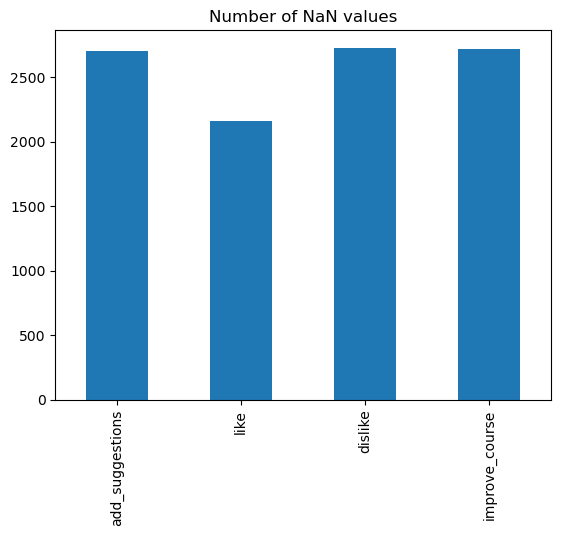

In [23]:
plot_nan_values(data)

In [24]:
type(data)

pandas.core.frame.DataFrame

# Remove duplicates and save processed data

In [25]:
# number of duplications
for col in data.columns:
    print(f'Number of duplicated values in {col}:', data[col].dropna().duplicated().sum())

Number of duplicated values in add_suggestions: 79

Number of duplicated values in like: 141

Number of duplicated values in dislike: 38

Number of duplicated values in improve_course: 46

In [26]:
# np.nan
processed_data = {
    col_name: [value for value in data[col_name].dropna().drop_duplicates()] for col_name in data.columns
}

In [27]:
processed_data['like'][:4]

['المقرر بشكل عام',
 'طريقة الشرح',
 'عضو التدريس ومحتوى المقرر',
 'تطوير مهارات القيادة']

In [28]:
save_path = '../../data/processed/porcessed_data.json'

with open(save_path, 'w') as f:
    json.dump(processed_data, f)

In [29]:
for k, v in processed_data.items():
    print(f'({k}) column has {len(v)} sentences.')

(add_suggestions) column has 297 sentences.

(like) column has 779 sentences.

(dislike) column has 313 sentences.

(improve_course) column has 312 sentences.

# Plot sentence lengths

In [30]:
text = []
for k, v in processed_data.items():
    text.extend((v))

text = sorted(set(text))
print(len(text))

1610

In [31]:
text_length = [len(sentence.split()) for sentence in text]

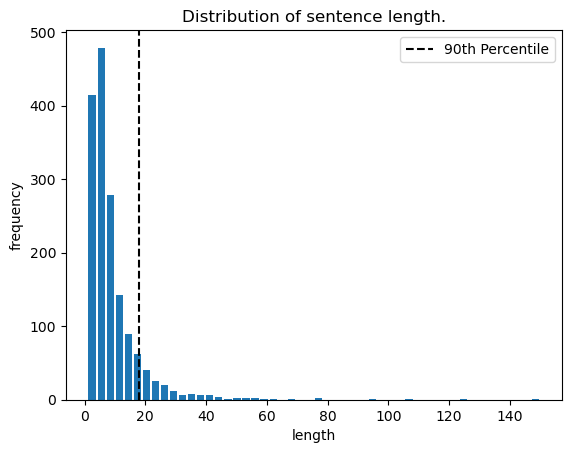

In [32]:
plt.hist(text_length, bins=50, rwidth=0.8)
plt.title('Distribution of sentence length.')
plt.xlabel('length')
plt.ylabel('frequency')

percentile_90 = np.percentile(text_length, 90)
plt.axvline(percentile_90, color='k', linestyle='--', label='90th Percentile')
plt.legend()
plt.show()